In [85]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function


import random
import numpy as np
from collections import deque

import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

import sys
sys.path.insert(0, '../src/data')
import auxiliary_functions, make_dataset
from auxiliary_functions import convert_miles_to_minutes_nyc, list_of_output_predictions_to_direction

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Dictionary : Yellow Taxi Cab
- VendorID A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- tpep_pickup_datetime The date and time when the meter was engaged.
- tpep_dropoff_datetime The date and time when the meter was disengaged.
- Passenger_count The number of passengers in the vehicle.
 This is a driver-entered value.
- Trip_distance The elapsed trip distance in miles reported by the taximeter.
- Pickup_longitude Longitude where the meter was engaged.
- Pickup_latitude Latitude where the meter was engaged.
- RateCodeID The final rate code in effect at the end of the trip.
 1= Standard rate 
 2=JFK
 3=Newark
 4=Nassau or Westchester
 5=Negotiated fare
 6=Group ride
- Store_and_fwd_flag This flag indicates whether the trip record was held in vehicle
 memory before sending to the vendor, aka “store and forward,”
 because the vehicle did not have a connection to the server.
- Y= store and forward trip
- N= not a store and forward trip
- Dropoff_longitude Longitude where the meter was disengaged.
- Dropoff_ latitude Latitude where the meter was disengaged.
- Payment_type A numeric code signifying how the passenger paid for the trip.
 1= Credit card
 2= Cash
 3= No charge
 4= Dispute
 5= Unknown
 6= Voided trip
- Fare_amount The time-and-distance fare calculated by the meter.
- Extra Miscellaneous extras and surcharges. Currently, this only includes
 t he 0.50 and 1 rush hour and overnight charges.
 M TA_tax 0.50 MTA tax that is automatically triggered based on the metered
 rate in use.
- Improvement_surcharge 0.30 improvement surcharge assessed trips at the flag drop. The
- improvement surcharge began being levied in 2015.
- Tip_amount Tip amount – This field is automatically populated for credit card
 tips. Cash tips are not included.
- Tolls_amount Total amount of all tolls paid in trip.
- Total_amount The total amount charged to passengers. Does not include cash tips.

### Geohash dictionary the distance between geohashes based on matching characters, in meters.
_PRECISION = {
    0: 20000000,
    1: 5003530,
    2: 625441,
    3: 123264,
    4: 19545,
    5: 3803,
    6: 610,
    7: 118,
    8: 19,
    9: 3.71,
    10: 0.6,
}

### Average speed of taxis in Manhattan
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df, final_data_structure= make_dataset.main()

Opening up data
Group data
Creating the final data structure


In [10]:
# sample of the final data structure
final_data_structure[1110]['Zct8R']

[(14.765, 20, 0.7382499999630875),
 (12.815200000000004, 20, 0.6407599999679622),
 (12.74269230769231, 20, 0.6371346153527588),
 (11.510000000000003, 10, 1.1509999998849003),
 (13.840303030303033, 20, 0.6920151514805509),
 (13.59464285714286, 10, 1.3594642855783396),
 (12.480285714285715, 10, 1.2480285713037687),
 (13.586486486486491, 10, 1.3586486485127842),
 (11.100800000000003, 10, 1.1100799998889923),
 (9.999090909090913, 10, 0.9999090908091004),
 (12.540000000000001, 10, 1.2539999998746),
 (16.846790123456774, 20, 0.8423395061307217),
 (14.20904761904762, 20, 0.7104523809168584),
 (13.19685714285715, 10, 1.3196857141537464),
 (13.012058823529417, 10, 1.3012058822228212),
 (10.919736842105266, 10, 1.0919736841013292),
 (12.727187500000001, 20, 0.6363593749681821),
 (10.53694444444445, 10, 1.0536944443390754),
 (13.375609756097564, 10, 1.3375609754760003),
 (15.676341463414628, 10, 1.5676341461846994),
 (15.99925, 20, 0.7999624999600019),
 (12.792558139534883, 10, 1.2792558138255627

In [11]:
# the data
taxi_yellowcab_df.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,trip_time_minutes
0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,...,0.0,0.0,0.3,8.8,Zct8X,dr5rsx,1,0,dr5rsx,10
1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,...,0.0,0.0,0.3,19.3,Zct8c,dr5rtk,1,0,dr5rtk,30
2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,...,0.0,0.0,0.3,34.3,Zct5T,dr72j1,1,0,dr72j1,60
3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,...,0.0,0.0,0.3,17.3,Zct8Q,dr5rkc,1,0,dr5rkc,30
4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,...,0.0,0.0,0.3,8.8,Zc4oK,dr5rue,1,0,dr5rue,10
5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,...,0.0,0.0,0.3,20.3,Zct9J,dr5ryh,1,18,dr5ryh,30
6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,...,0.0,0.0,0.3,27.3,Zct8Q,dr72hc,1,26,dr72hc,40
7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,...,0.0,0.0,0.3,10.3,Zct9J,dr5ru7,1,11,dr5ru7,10
8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,...,0.0,0.0,0.3,19.3,Zc4oj,dr72mz,1,11,dr72mz,40
9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,...,0.0,0.0,0.3,12.8,Zct8R,dr5rkp,1,11,dr5rkp,20


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [123]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [152]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
list_of_output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take
- 1) Assuming you can go to every geohash (not possible)
- 2) In a day

In [125]:
# How many total paths are there? Each hash has eight neighbors 9**(3086+1)-1 (nine because can go back to same node)?
len(str(9**(3086+1)-1))

2946

In [126]:
9**(3086+1)-1

5579902870072604520781768502574482838546250466479394679120423233865123088592389991017461272488545405947765927162973387932045022005649438467688986550554080894185396774521488734899097433560201783213247514879997422269344026429651880573126493783573017994538196988029386545666816019319724615929720075669428086745884640756582690931484927980211133964573153734354721166826860261443322744314068689260103258399221523423491086073730155749220812428859992609815473080036165549503067436533672536096771042279671074422297963752772874873262444107295806867918725513984107605763341504022359073978439306375832553510771427946743018584229245035857393349814173061883996462261039520359742300610335672925845092698960913043438763887415592711932793128251312269833014286519114532326985228736857198782870587228937486706651907834860273160740002634916801037884326483826754329680352728721901803066745050394781620769573763795067015177936781922172428117223520055663389664154063119619522401577699134093725128957954328067620982202878843

In [127]:
# how man geohashes can you visit in a day?
9**(288+1)-1

597152463056842341908762024185418685054207056332314478347827352460764734375345345870603172419123868750295983288569263632574908815378078302580224585346653298324734195047557342194681056539164109295762036073231747763356454020325313392530348032063147781100083853910415445388545288

In [128]:
len(str(9**(288+1)-1))

276

# Heat Map of the most profitable geohashes

In [12]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [13]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [14]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [15]:
# can only plot 2k values on google maps

In [16]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

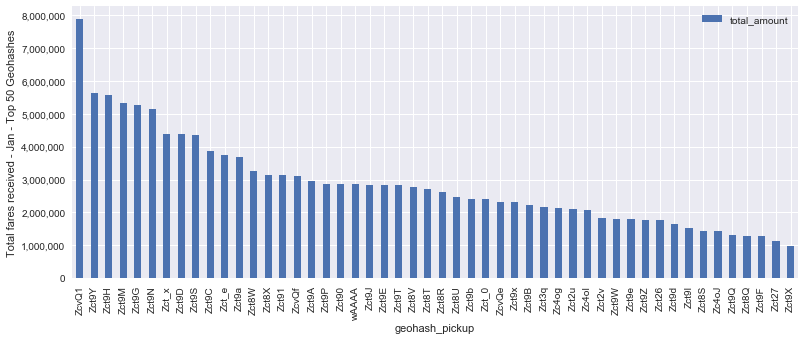

In [17]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into ten minute intervals( the time to traverse a geohash of ~3803 meters).
### Note: This code is already run in the make_data.main() call in the first cell
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [20]:

    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [21]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

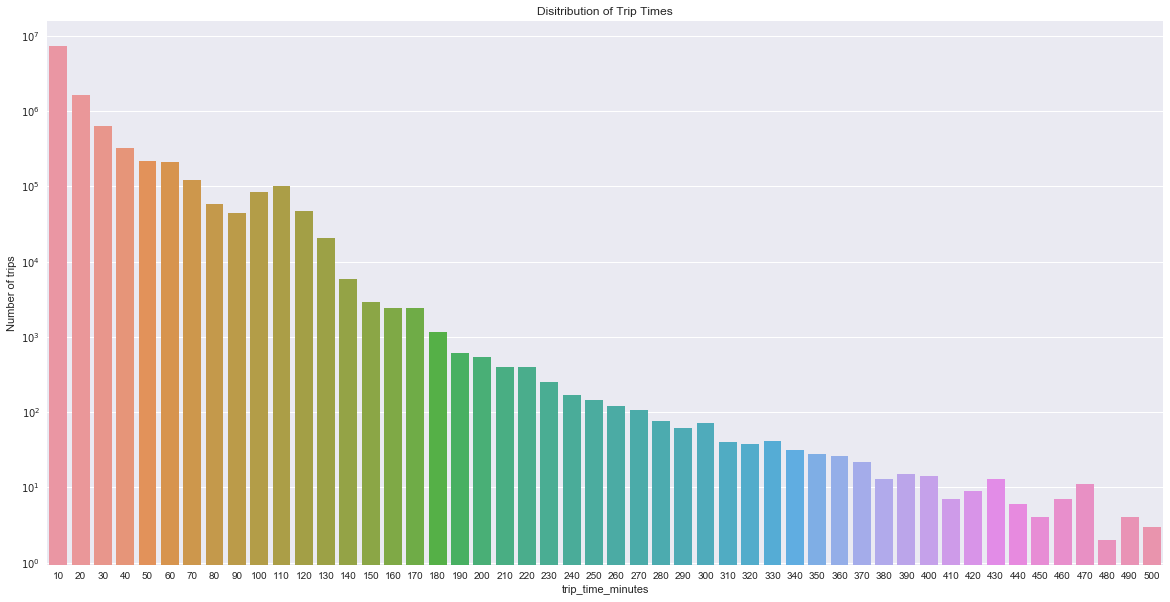

In [22]:
plt.figure(figsize=(20,10))
grid = sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
grid.set( yscale="log")
plt.ylabel('Number of trips')
plt.title('Disitribution of Trip Times')

## Index the geohashes to a number
#### List of possible times

In [24]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(list_of_unique_geohashes)

3086

In [25]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [26]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [186]:
list_of_inverse_heohash_index

defaultdict(str,
            {0: 'Zct8X',
             1: 'Zct8c',
             2: 'Zct5T',
             3: 'Zct8Q',
             4: 'Zc4oK',
             5: 'Zct9J',
             6: 'Zc4oj',
             7: 'Zct8R',
             8: 'Zct3r',
             9: 'Zct9a',
             10: 'Zct8T',
             11: 'Zct3q',
             12: 'Zct8S',
             13: 'Zct9T',
             14: 'Zc4oM',
             15: 'Zct9W',
             16: 'Zct5w',
             17: 'Zct8W',
             18: 'Zct9B',
             19: 'Zct8V',
             20: 'Zct8P',
             21: 'Zct91',
             22: 'Zct9H',
             23: 'Zct9m',
             24: 'Zct8U',
             25: 'Zct9c',
             26: 'Zct8Y',
             27: 'Zct9e',
             28: 'wAAAA',
             29: 'Zc4oO',
             30: 'Zct6T',
             31: 'Zct9M',
             32: 'Zc4og',
             33: 'Zct5f',
             34: 'Zct9R',
             35: 'Zct8d',
             36: 'Zct9D',
             37: 'Zct9N',
     

In [71]:
hours = [str(_) for _ in range(24)]
minutes = [str(_) for _ in range(0,60,10)]
minutes.append('00')
list_of_time_index =[]
for h in hours:
    for m in minutes:

        list_of_time_index.append(int(str(h)+str(m)))
list_of_time_index = list(set(list_of_time_index))

In [74]:
list_of_time_index

[0,
 2050,
 1540,
 1030,
 520,
 10,
 1550,
 1040,
 530,
 20,
 1050,
 540,
 30,
 550,
 40,
 50,
 2100,
 60,
 2110,
 1600,
 70,
 2120,
 1610,
 1100,
 80,
 2130,
 1620,
 1110,
 600,
 90,
 2140,
 1630,
 1120,
 610,
 100,
 2150,
 1640,
 1130,
 620,
 110,
 1650,
 1140,
 630,
 120,
 1150,
 640,
 130,
 650,
 140,
 150,
 2200,
 160,
 2210,
 1700,
 170,
 2220,
 1710,
 1200,
 180,
 2230,
 1720,
 1210,
 700,
 190,
 2240,
 1730,
 1220,
 710,
 200,
 2250,
 1740,
 1230,
 720,
 210,
 1750,
 1240,
 730,
 220,
 1250,
 740,
 230,
 750,
 240,
 250,
 2300,
 2310,
 1800,
 2320,
 1810,
 1300,
 2330,
 1820,
 1310,
 800,
 2340,
 1830,
 1320,
 810,
 300,
 2350,
 1840,
 1330,
 820,
 310,
 1850,
 1340,
 830,
 320,
 1350,
 840,
 330,
 850,
 340,
 350,
 1900,
 1910,
 1400,
 1920,
 1410,
 900,
 1930,
 1420,
 910,
 400,
 1940,
 1430,
 920,
 410,
 1950,
 1440,
 930,
 420,
 1450,
 940,
 430,
 950,
 440,
 450,
 2000,
 2010,
 1500,
 2020,
 1510,
 1000,
 2030,
 1520,
 1010,
 500,
 2040,
 1530,
 1020,
 510]

In [30]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute',
       'geohash_dropoff', 'trip_time_minutes'],
      dtype='object')

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

In [41]:
## Actor
HIDDEN1_UNITS=10
HIDDEN2_UNITS=20
state_size=5
print("Now we build the model")
S = Input(shape=[state_size])
h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)

Steering = Dense(1,activation='tanh')(h1)   
Acceleration = Dense(1,activation='sigmoid')(h1)   
Brake = Dense(1,activation='sigmoid')(h1)   
V = Concatenate([Steering,Acceleration,Brake])

model = Model(inputs=S,output=[Steering,Acceleration,Brake])
model.summary()
print("We finished building the model")


Now we build the model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
dense_75 (Dense)                 (None, 10)            60                                           
____________________________________________________________________________________________________
dense_76 (Dense)                 (None, 20)            220                                          
____________________________________________________________________________________________________
dense_77 (Dense)                 (None, 1)             21                                           
____________________________________________________________________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [50]:
## Critic
action_dim = 100
S = Input(shape=[state_size])
A = Input(shape=[action_dim],name='action2')    
w1 = Dense(HIDDEN1_UNITS, activation='relu')(S)
a1 = Dense(HIDDEN2_UNITS, activation='linear')(A)
h1 = Dense(HIDDEN2_UNITS, activation='linear')(w1)
h2 = Add(h1,a1)    
h3 = Dense(HIDDEN2_UNITS, activation='relu')(h2)
V = Dense(action_dim,activation='linear')(h3) 

model = Concatenate(input=[S,A],output=V)

adam = Adam(lr=self.LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)
print("We finished building the model")

TypeError: __init__() takes 1 positional argument but 3 were given

In [207]:
# parameters
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 9 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 20. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 16 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4

In [137]:
##define some test inputs , time, state
X = np.array([[100,200]])
X.shape

(1, 2)

In [129]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_simple = Sequential()
model_simple.add(Dense(100, activation='relu', input_shape= (2,)))
model_simple.add(Dropout(.3))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dropout(.3))
model_simple.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
adam = Adam(lr=LEARNING_RATE)
model_simple.compile(loss='mse',optimizer=adam)
model_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               300       
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 909       
Total params: 11,309.0
Trainable params: 11,309.0
Non-trainable params: 0.0
_________________________________________________________________


In [130]:
model_simple.predict(X)

array([[  9.99997973e-01,   7.44566100e-22,   5.85626305e-29,
          5.43069256e-10,   2.07572225e-06,   5.74479570e-12,
          1.53014088e-22,   1.13071340e-18,   9.52187090e-15]], dtype=float32)

In [256]:
list_of_geohash_index[np.random.choice(list_of_unique_geohashes)] # index of geohash

770

In [259]:
np.random.choice(list_of_time_index) # time

1410

In [271]:
np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]]])
    

array([[ 605, 2775]])

In [278]:
random.randrange(ACTIONS)

8

In [216]:
def trainNetworkNeuralNetworkTaxicab(model, list_of_unique_geohashes):
    # Code adapted from https://github.com/yanpanlau/Keras-FlappyBird/blob/master/qlearn.py
    ## pick a random state and time to start at
    
    # store the previous observations in replay memory
    D = deque()
    
    # get the first state by randomlly choosing a geohash to start at and random time to start at
    # Assume that the first state has no reward associated with it
    starting_geohash = np.random.choice(list_of_unique_geohashes)
    starting_time = np.random.choice(list_of_time_index)
    s_time = starting_time
    s_geohash = list_of_geohash_index[starting_geohash]
    
    s_t = np.array([[starting_time,
                     s_geohash]])
    print(s_t,'starting time and geohash index')
    args = {'None':0}
    try:
        args['mode'] == 'Run' ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    except KeyError:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON
        
    #start your observations
    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        print(t, ' t')
        #choose a random action action epsilon greedy
        if t % FRAME_PER_ACTION == 0: ## will always choose this if frame per action is 1
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS) # Randomlly choose another geohash to go to
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input the time followed by the geohash index
                max_Q = np.argmax(q)  # find the position of the highest probability (which direction to go in)
                action_index = max_Q
                a_t[max_Q] = 1
                
        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
            
        print(a_t,'a_t')
        print(action_index,'action Index')
        print(list_of_output_predictions_to_direction[np.argmax(a_t)],'direction to take')

            
        #run the selected action and observed next state and reward
        # We need to find the neighbors to the geohash that we started at
        
        #Get the neighbors from the current geohash - convert back to string
        current_geohash_string = list_of_inverse_heohash_index[s_geohash]
        neighbors = gh.neighbors(current_geohash_string)
        # Get the direction we should go
        direction_to_move_to = list_of_output_predictions_to_direction[action_index]
        # Get the geohash of the direction we moved to
        if direction_to_move_to =='stay':
            new_geohash = starting_geohash # stay in current geohash, get the index of said geohash
            possible_rewards = np.array(final_data_structure[starting_time][new_geohash]) 
            # hash with the letters  of the geohash above
            new_geohash = list_of_geohash_index[starting_geohash]
            print(new_geohash,'new geohash stay')
        else:
            new_geohash = neighbors[direction_to_move_to]## give us the geohash to move to next
            print(new_geohash,'new geohash moved to new mplace')
        print(new_geohash,'new geohash we moved to')
        
        # get the reward of the geohash we just moved to (this is the ratio of fare /time of trip)
        possible_rewards = np.array(final_data_structure[starting_time][new_geohash])

        if len (possible_rewards) ==0:
            r_t = 0 ## we do not have information for this time and geohash, don't go here. No reward
            s_time1 = s_time+10
        else:
            r_t =  possible_rewards[np.random.randint(0,len(possible_rewards))][2] # get the ratio of fare / trip time
            # get the trip length
            print('trip length',possible_rewards[np.random.randint(0,len(possible_rewards))][1] )
            s_time1 = s_time + possible_rewards[np.random.randint(0,len(possible_rewards))][1] 
            #r_t = np.random.choice(possible_rewards)
        print(r_t,'reward')
        print(s_time,'current time')
        s_geohash1 = list_of_geohash_index[new_geohash]
        print(s_time1,s_geohash1 , 'time1, geohash1')
       


        # store the transition in D
        if s_time1 <= 2350: # The last possible time for a trip
            terminal = 0
        else: # the day is over, pick a new starting geohash and time
            terminal = 1
            print('Picking a new starting geohash and time')
            s_time1 = np.random.choice(list_of_time_index)
            s_geohash1 =   list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]
    
        # Terminal should be a one if the day is over or a zero otherwise
        # time, geohash, action index, reward, time1, geohash 1, terminal
        D.append((s_time,s_geohash, action_index, r_t, s_time1,s_geohash1, terminal))
        
        if len(D) > REPLAY_MEMORY:
            D.popleft()
        print('Finished iteration -----')
    
        
        ######### NEXT SEXTION #########
        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            print(minibatch,' mini batch')
            print(len(minibatch),'minibatch length')
            inputs = []
            
            inputs = np.zeros((BATCH, s_t.shape[1]))   #16, 2
            print (inputs.shape)
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #16, 9

            #Now we do the experience replay
            for i in range(0, len(minibatch)): # 0 -15 for batch 16
                s_time_t = minibatch[i][0]
                s_geohash_t = minibatch[i][1]
                action_t = minibatch[i][2] # action index
                reward_t = minibatch[i][3]
                s_time_t1 = minibatch[i][4]
                s_geohash_t1 = minibatch[i][5]
                terminal = minibatch[i][6]
                
#                 state_t = minibatch[i][0]
#                 action_t = minibatch[i][1]   #This is action index
#                 reward_t = minibatch[i][2]
#                 state_t1 = minibatch[i][3]
#                 terminal = minibatch[i][4]
                # if terminated, only equals reward
                for col in range(inputs.shape[1]-1):
                    inputs[i,col] = s_time_t   #Save the time and geohash in the inputs to the model
                    inputs[i,col+1] = s_geohash_t
                
                state_t = np.array([[s_time_t, s_geohash_t]])
                state_t1 = np.array([[s_time_t1,s_geohash_t1]])
                
                targets[i] = model.predict(state_t)  # update entire row
                Q_sa = model.predict(state_t1)
                

                if terminal==1: ## The day ended, pick a new starting geohash and time 
                    targets[i, action_t] = reward_t

    
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa) ## exponential discounting for each memory

            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)


        s_time = s_time1
        s_geohash = s_geohash1
        t = t + 1


        

In [189]:
final_data_structure[110]['Zct3r']

[(17.240000000000006, 20, 0.8619999999569002),
 (11.945454545454545, 20, 0.5972727272428636),
 (13.2725, 20, 0.6636249999668188),
 (31.106666666666666, 50, 0.6221333333208907),
 (17.767000000000003, 20, 0.8883499999555826),
 (17.21111111111111, 20, 0.8605555555125276),
 (9.675, 10, 0.9674999999032501),
 (11.2575, 10, 1.125749999887425),
 (15.112, 20, 0.75559999996222),
 (14.197419354838711, 20, 0.709870967706442),
 (16.485, 20, 0.8242499999587874),
 (15.808333333333332, 20, 0.7904166666271457),
 (17.115000000000002, 20, 0.8557499999572126),
 (14.816666666666668, 20, 0.7408333332962918),
 (13.285833333333334, 20, 0.6642916666334522),
 (12.885, 20, 0.6442499999677875),
 (14.605161290322584, 20, 0.7302580644796163),
 (15.134500000000006, 20, 0.756724999962164),
 (17.54, 30, 0.5846666666471777),
 (15.219999999999999, 20, 0.7609999999619499),
 (11.339999999999998, 10, 1.1339999998865997),
 (19.3275, 20, 0.9663749999516813),
 (17.2425, 20, 0.8621249999568937),
 (15.986666666666666, 20, 0.799

In [217]:
c=0
while c < 10:
    trainNetworkNeuralNetworkTaxicab(model_simple, list_of_unique_geohashes)
    c+=1

[[1610 2735]] starting time and geohash index
0  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
ZcveR new geohash moved to new mplace
ZcveR new geohash we moved to
0 reward
1610 current time
1620 2565 time1, geohash1
Finished iteration -----
1  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zcvc- new geohash moved to new mplace
Zcvc- new geohash we moved to
0 reward
1620 current time
1630 0 time1, geohash1
Finished iteration -----
2  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct9A new geohash moved to new mplace
Zct9A new geohash we moved to
trip length 10.0
1.37616666653 reward
1630 current time
1640.0 52 time1, geohash1
Finished iteration -----
3  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3r new geohash moved to new mplace
Zct3r new geohash we moved to
trip length 20.0
1.23054999988 reward
1640.0 current time
1650.0 8 time1, geohash1
Finishe

0 action Index
nw direction to take
Zct9A new geohash moved to new mplace
Zct9A new geohash we moved to
trip length 10.0
1.04583636353 reward
1900.0 current time
1910.0 52 time1, geohash1
Finished iteration -----
[(1880.0, 1060, 0, 0, 1890.0, 1386, 0), (1690.0, 1154, 0, 0, 1700.0, 1060, 0), (1620, 2565, 0, 0, 1630, 0, 0), (1670.0, 414, 0, 0, 1680.0, 1486, 0), (1700.0, 1060, 0, 0, 1710.0, 1386, 0), (1650.0, 8, 0, 0, 1660.0, 565, 0), (1900.0, 0, 0, 1.0458363635317798, 1910.0, 52, 0), (1840.0, 565, 0, 0, 1850.0, 414, 0), (1870.0, 1154, 0, 0, 1880.0, 1060, 0), (1810.0, 52, 0, 1.30979999986902, 1830.0, 8, 0), (1680.0, 1486, 0, 0, 1690.0, 1154, 0), (1720.0, 0, 0, 1.158303030187199, 1730.0, 52, 0), (1610, 2735, 0, 0, 1620, 2565, 0), (1790.0, 0, 0, 1.0458363635317798, 1810.0, 52, 0), (1630, 0, 0, 1.3761666665290497, 1640.0, 52, 0), (1710.0, 1386, 0, 0, 1720.0, 0, 0)]  mini batch
16 minibatch length
(16, 2)
27  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3

1.12839130423 reward
2020.0 current time
2030.0 18 time1, geohash1
Finished iteration -----
[(1890.0, 1386, 0, 0, 1900.0, 0, 0), (1710.0, 1386, 0, 0, 1720.0, 0, 0), (1930.0, 8, 0, 0, 1940.0, 565, 0), (2000.0, 0, 1, 1.1667866665499873, 2020.0, 45, 0), (2020.0, 45, 0, 1.1283913042349873, 2030.0, 18, 0), (1850.0, 414, 0, 0, 1860.0, 1486, 0), (1950.0, 414, 0, 0, 1960.0, 1486, 0), (1650.0, 8, 0, 0, 1660.0, 565, 0), (1660.0, 565, 0, 0, 1670.0, 414, 0), (1770.0, 396, 0, 0, 1780.0, 891, 0), (1860.0, 1486, 0, 0, 1870.0, 1154, 0), (1910.0, 52, 0, 0.81328571424504992, 1930.0, 8, 0), (1640.0, 52, 0, 1.2305499998769451, 1650.0, 8, 0), (1670.0, 414, 0, 0, 1680.0, 1486, 0), (1750.0, 8, 6, 0, 1760.0, 1536, 0), (1970.0, 1154, 0, 0, 1980.0, 1060, 0)]  mini batch
16 minibatch length
(16, 2)
37  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3u new geohash moved to new mplace
Zct3u new geohash we moved to
trip length 20.0
1.09566666656 reward
2030.0 current time
2040.0 

2120.0 current time
2130.0 1060 time1, geohash1
Finished iteration -----
[(1850.0, 414, 0, 0, 1860.0, 1486, 0), (1690.0, 1154, 0, 0, 1700.0, 1060, 0), (1980.0, 1060, 0, 0, 1990.0, 1386, 0), (1990.0, 1386, 0, 0, 2000.0, 0, 0), (1630, 0, 0, 1.3761666665290497, 1640.0, 52, 0), (1790.0, 0, 0, 1.0458363635317798, 1810.0, 52, 0), (1620, 2565, 0, 0, 1630, 0, 0), (1660.0, 565, 0, 0, 1670.0, 414, 0), (2050.0, 0, 0, 1.313953124868604, 2060.0, 52, 0), (1780.0, 891, 0, 0, 1790.0, 0, 0), (1880.0, 1060, 0, 0, 1890.0, 1386, 0), (2020.0, 45, 0, 1.1283913042349873, 2030.0, 18, 0), (2000.0, 0, 1, 1.1667866665499873, 2020.0, 45, 0), (1870.0, 1154, 0, 0, 1880.0, 1060, 0), (1730.0, 52, 0, 1.4627777776314996, 1750.0, 8, 0), (1710.0, 1386, 0, 0, 1720.0, 0, 0)]  mini batch
16 minibatch length
(16, 2)
46  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3X new geohash moved to new mplace
Zct3X new geohash we moved to
0 reward
2130.0 current time
2140.0 1386 time1, geohash1
Fin

58  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3r new geohash moved to new mplace
Zct3r new geohash we moved to
trip length 10.0
0.693619047584 reward
2270.0 current time
2290.0 8 time1, geohash1
Finished iteration -----
[(2240.0, 1386, 0, 0, 2250.0, 0, 0), (1680.0, 1486, 0, 0, 1690.0, 1154, 0), (2030.0, 18, 0, 1.0956666665571002, 2040.0, 92, 0), (1940.0, 565, 0, 0, 1950.0, 414, 0), (1980.0, 1060, 0, 0, 1990.0, 1386, 0), (1630, 0, 0, 1.3761666665290497, 1640.0, 52, 0), (1840.0, 565, 0, 0, 1850.0, 414, 0), (1960.0, 1486, 0, 0, 1970.0, 1154, 0), (2050.0, 0, 0, 1.313953124868604, 2060.0, 52, 0), (2160.0, 52, 0, 1.3573999998642601, 2180.0, 8, 0), (2200.0, 414, 0, 0, 2210.0, 1486, 0), (1970.0, 1154, 0, 0, 1980.0, 1060, 0), (1610, 2735, 0, 0, 1620, 2565, 0), (2120.0, 1154, 0, 0, 2130.0, 1060, 0), (2000.0, 0, 1, 1.1667866665499873, 2020.0, 45, 0), (2090.0, 565, 0, 0, 2100.0, 414, 0)]  mini batch
16 minibatch length
(16, 2)
59  t
[ 1.  0.  0.  0.  0.  0.

nw direction to take
Zct9A new geohash moved to new mplace
Zct9A new geohash we moved to
trip length 20.0
1.15830303019 reward
850 current time
860.0 52 time1, geohash1
Finished iteration -----
[(1780.0, 891, 0, 0, 1790.0, 0, 0), (1700.0, 1060, 0, 0, 1710.0, 1386, 0), (840, 880, 0, 0, 850, 0, 0), (1830.0, 8, 0, 0, 1840.0, 565, 0), (2090.0, 565, 0, 0, 2100.0, 414, 0), (2320.0, 1486, 0, 0, 2330.0, 1154, 0), (1620, 2565, 0, 0, 1630, 0, 0), (2250.0, 0, 0, 0.71990384611785074, 2270.0, 52, 0), (2100.0, 414, 0, 0, 2110.0, 1486, 0), (2190.0, 565, 0, 0, 2200.0, 414, 0), (1970.0, 1154, 0, 0, 1980.0, 1060, 0), (2220.0, 1154, 0, 0, 2230.0, 1060, 0), (1730.0, 52, 0, 1.4627777776314996, 1750.0, 8, 0), (2030.0, 18, 0, 1.0956666665571002, 2040.0, 92, 0), (1790.0, 0, 0, 1.0458363635317798, 1810.0, 52, 0), (1720.0, 0, 0, 1.158303030187199, 1730.0, 52, 0)]  mini batch
16 minibatch length
(16, 2)
68  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3r new geohash moved to

79  t
----------Random Action----------
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.] a_t
4 action Index
stay direction to take
2735 new geohash stay
2735 new geohash we moved to
0 reward
990.0 current time
1000.0 0 time1, geohash1
Finished iteration -----
[(940.0, 1386, 0, 0, 950.0, 0, 0), (2270.0, 52, 0, 0.69361904758436677, 2290.0, 8, 0), (980.0, 8, 0, 0, 990.0, 565, 0), (1980.0, 1060, 0, 0, 1990.0, 1386, 0), (2180.0, 8, 0, 0, 2190.0, 565, 0), (1970.0, 1154, 0, 0, 1980.0, 1060, 0), (2090.0, 565, 0, 0, 2100.0, 414, 0), (2240.0, 1386, 0, 0, 2250.0, 0, 0), (2080.0, 8, 0, 0, 2090.0, 565, 0), (2150.0, 0, 0, 1.2224225350890245, 2160.0, 52, 0), (930.0, 1060, 0, 0, 940.0, 1386, 0), (1720.0, 0, 0, 1.158303030187199, 1730.0, 52, 0), (1630, 0, 0, 1.3761666665290497, 1640.0, 52, 0), (1930.0, 8, 0, 0, 1940.0, 565, 0), (1730.0, 52, 0, 1.4627777776314996, 1750.0, 8, 0), (1660.0, 565, 0, 0, 1670.0, 414, 0)]  mini batch
16 minibatch length
(16, 2)
80  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Ind

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3s new geohash moved to new mplace
Zct3s new geohash we moved to
0 reward
1090.0 current time
1100.0 565 time1, geohash1
Finished iteration -----
[(900.0, 414, 0, 0, 910.0, 1486, 0), (980.0, 8, 0, 0, 990.0, 565, 0), (1760.0, 1536, 0, 0, 1770.0, 396, 0), (2220.0, 1154, 0, 0, 2230.0, 1060, 0), (1710.0, 1386, 0, 0, 1720.0, 0, 0), (2100.0, 414, 0, 0, 2110.0, 1486, 0), (1880.0, 1060, 0, 0, 1890.0, 1386, 0), (1630, 0, 0, 1.3761666665290497, 1640.0, 52, 0), (1060.0, 0, 0, 1.1940298506268652, 1080.0, 52, 0), (1960.0, 1486, 0, 0, 1970.0, 1154, 0), (1790.0, 0, 0, 1.0458363635317798, 1810.0, 52, 0), (1690.0, 1154, 0, 0, 1700.0, 1060, 0), (1000.0, 0, 0, 1.2908999998709096, 1010.0, 52, 0), (2300.0, 565, 0, 0, 2310.0, 414, 0), (1660.0, 565, 0, 0, 1670.0, 414, 0), (2150.0, 0, 0, 1.2224225350890245, 2160.0, 52, 0)]  mini batch
16 minibatch length
(16, 2)
89  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw di

nw direction to take
Zct3P new geohash moved to new mplace
Zct3P new geohash we moved to
0 reward
1220.0 current time
1230.0 0 time1, geohash1
Finished iteration -----
[(1790.0, 0, 0, 1.0458363635317798, 1810.0, 52, 0), (1160.0, 0, 0, 1.2423088234051807, 1170.0, 52, 0), (1850.0, 414, 0, 0, 1860.0, 1486, 0), (2220.0, 1154, 0, 0, 2230.0, 1060, 0), (1170.0, 52, 0, 0.81328571424504992, 1190.0, 8, 0), (2310.0, 414, 0, 0, 2320.0, 1486, 0), (2190.0, 565, 0, 0, 2200.0, 414, 0), (1870.0, 1154, 0, 0, 1880.0, 1060, 0), (1880.0, 1060, 0, 0, 1890.0, 1386, 0), (1840.0, 565, 0, 0, 1850.0, 414, 0), (1190.0, 8, 0, 0, 1200.0, 565, 0), (1650.0, 8, 0, 0, 1660.0, 565, 0), (980.0, 8, 0, 0, 990.0, 565, 0), (1860.0, 1486, 0, 0, 1870.0, 1154, 0), (2320.0, 1486, 0, 0, 2330.0, 1154, 0), (1950.0, 414, 0, 0, 1960.0, 1486, 0)]  mini batch
16 minibatch length
(16, 2)
101  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct9A new geohash moved to new mplace
Zct9A new geohash we moved t

Zct3w new geohash we moved to
0 reward
1340.0 current time
1350.0 1486 time1, geohash1
Finished iteration -----
[(980.0, 8, 0, 0, 990.0, 565, 0), (2040.0, 92, 4, 0, 2050.0, 0, 0), (1230.0, 0, 0, 1.3761666665290497, 1250.0, 52, 0), (1150.0, 1386, 0, 0, 1160.0, 0, 0), (1750.0, 8, 6, 0, 1760.0, 1536, 0), (1620, 2565, 0, 0, 1630, 0, 0), (1970.0, 1154, 0, 0, 1980.0, 1060, 0), (1130.0, 1154, 0, 0, 1140.0, 1060, 0), (1780.0, 891, 0, 0, 1790.0, 0, 0), (1900.0, 0, 0, 1.0458363635317798, 1910.0, 52, 0), (1010.0, 52, 0, 1.4627777776314996, 1020.0, 8, 0), (1960.0, 1486, 0, 0, 1970.0, 1154, 0), (1870.0, 1154, 0, 0, 1880.0, 1060, 0), (1720.0, 0, 0, 1.158303030187199, 1730.0, 52, 0), (2240.0, 1386, 0, 0, 2250.0, 0, 0), (2090.0, 565, 0, 0, 2100.0, 414, 0)]  mini batch
16 minibatch length
(16, 2)
112  t
----------Random Action----------
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.] a_t
7 action Index
s direction to take
Zct3l new geohash moved to new mplace
Zct3l new geohash we moved to
0 reward
1350.0 current

126  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3w new geohash moved to new mplace
Zct3w new geohash we moved to
0 reward
1500.0 current time
1510.0 1486 time1, geohash1
Finished iteration -----
[(1810.0, 52, 0, 1.30979999986902, 1830.0, 8, 0), (1440.0, 0, 0, 1.2423088234051807, 1450.0, 52, 0), (1680.0, 1486, 0, 0, 1690.0, 1154, 0), (1220.0, 891, 0, 0, 1230.0, 0, 0), (1780.0, 891, 0, 0, 1790.0, 0, 0), (910.0, 1486, 0, 0, 920.0, 1154, 0), (1340.0, 414, 0, 0, 1350.0, 1486, 0), (2100.0, 414, 0, 0, 2110.0, 1486, 0), (1010.0, 52, 0, 1.4627777776314996, 1020.0, 8, 0), (1320.0, 414, 0, 0, 1330.0, 1486, 0), (1130.0, 1154, 0, 0, 1140.0, 1060, 0), (860.0, 52, 0, 0.58653124997067341, 880.0, 8, 0), (1230.0, 0, 0, 1.3761666665290497, 1250.0, 52, 0), (2150.0, 0, 0, 1.2224225350890245, 2160.0, 52, 0), (1030.0, 565, 0, 0, 1040.0, 414, 0), (1140.0, 1060, 0, 0, 1150.0, 1386, 0)]  mini batch
16 minibatch length
(16, 2)
127  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a

138  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3X new geohash moved to new mplace
Zct3X new geohash we moved to
0 reward
1620.0 current time
1630.0 1386 time1, geohash1
Finished iteration -----
[(2020.0, 45, 0, 1.1283913042349873, 2030.0, 18, 0), (2240.0, 1386, 0, 0, 2250.0, 0, 0), (1900.0, 0, 0, 1.0458363635317798, 1910.0, 52, 0), (1300.0, 1154, 8, 0, 1310.0, 1486, 0), (1550.0, 0, 0, 1.2466470586988636, 1560.0, 52, 0), (980.0, 8, 0, 0, 990.0, 565, 0), (1830.0, 8, 0, 0, 1840.0, 565, 0), (1110.0, 414, 0, 0, 1120.0, 1486, 0), (1680.0, 1486, 0, 0, 1690.0, 1154, 0), (1700.0, 1060, 0, 0, 1710.0, 1386, 0), (1490.0, 565, 0, 0, 1500.0, 414, 0), (1130.0, 1154, 0, 0, 1140.0, 1060, 0), (850, 0, 0, 1.158303030187199, 860.0, 52, 0), (2340.0, 1060, 0, 0, 2350.0, 1386, 0), (960.0, 52, 0, 1.4646363634899002, 980.0, 8, 0), (1190.0, 8, 0, 0, 1200.0, 565, 0)]  mini batch
16 minibatch length
(16, 2)
139  t
----------Random Action----------
[ 0.  0.  0.  0.  0.  0. 

1740.0 52 time1, geohash1
Finished iteration -----
[(1020.0, 8, 0, 0, 1030.0, 565, 0), (2190.0, 565, 0, 0, 2200.0, 414, 0), (2100.0, 414, 0, 0, 2110.0, 1486, 0), (2180.0, 8, 0, 0, 2190.0, 565, 0), (1290.0, 1486, 0, 0, 1300.0, 1154, 0), (1430.0, 1486, 6, 0, 1440.0, 0, 0), (2250.0, 0, 0, 0.71990384611785074, 2270.0, 52, 0), (1270.0, 565, 0, 0, 1280.0, 414, 0), (1050.0, 1486, 6, 0, 1060.0, 0, 0), (1790.0, 0, 0, 1.0458363635317798, 1810.0, 52, 0), (1770.0, 396, 0, 0, 1780.0, 891, 0), (1510.0, 1486, 0, 0, 1520.0, 1154, 0), (1340.0, 414, 0, 0, 1350.0, 1486, 0), (1210.0, 396, 0, 0, 1220.0, 891, 0), (1030.0, 565, 0, 0, 1040.0, 414, 0), (1930.0, 8, 0, 0, 1940.0, 565, 0)]  mini batch
16 minibatch length
(16, 2)
150  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3r new geohash moved to new mplace
Zct3r new geohash we moved to
trip length 10.0
1.35739999986 reward
1740.0 current time
1750.0 8 time1, geohash1
Finished iteration -----
[(1620, 2565, 0, 0, 1630, 0,

[(2120.0, 1154, 0, 0, 2130.0, 1060, 0), (1820.0, 0, 0, 0.66567045451217011, 1830.0, 52, 0), (1530.0, 1060, 0, 0, 1540.0, 1386, 0), (890.0, 565, 0, 0, 900.0, 414, 0), (1590.0, 414, 0, 0, 1600.0, 1486, 0), (2020.0, 45, 0, 1.1283913042349873, 2030.0, 18, 0), (2110.0, 1486, 0, 0, 2120.0, 1154, 0), (1640.0, 0, 0, 1.1936575341272093, 1650.0, 52, 0), (1830.0, 52, 0, 0.79174999996041251, 1850.0, 8, 0), (1060.0, 0, 0, 1.1940298506268652, 1080.0, 52, 0), (1770.0, 414, 0, 0, 1780.0, 1486, 0), (1720.0, 1386, 0, 0, 1730.0, 0, 0), (1540.0, 1386, 0, 0, 1550.0, 0, 0), (1810.0, 52, 0, 1.30979999986902, 1830.0, 8, 0), (1490.0, 565, 0, 0, 1500.0, 414, 0), (840, 880, 0, 0, 850, 0, 0)]  mini batch
16 minibatch length
(16, 2)
161  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3n new geohash moved to new mplace
Zct3n new geohash we moved to
0 reward
1860.0 current time
1870.0 414 time1, geohash1
Finished iteration -----
[(2130.0, 1060, 0, 0, 2140.0, 1386, 0), (990.0, 565,

[(860.0, 52, 0, 0.58653124997067341, 880.0, 8, 0), (1670.0, 565, 0, 0, 1680.0, 414, 0), (1760.0, 565, 0, 0, 1770.0, 414, 0), (1790.0, 1154, 0, 0, 1800.0, 1060, 0), (890.0, 565, 0, 0, 900.0, 414, 0), (1040.0, 414, 0, 0, 1050.0, 1486, 0), (1830.0, 52, 0, 0.79174999996041251, 1850.0, 8, 0), (850, 0, 0, 1.158303030187199, 860.0, 52, 0), (2310.0, 414, 0, 0, 2320.0, 1486, 0), (1690.0, 1154, 0, 0, 1700.0, 1060, 0), (1550.0, 0, 0, 1.2466470586988636, 1560.0, 52, 0), (2350.0, 1386, 0, 0, 840, 880, 1), (2100.0, 414, 0, 0, 2110.0, 1486, 0), (1720.0, 0, 0, 1.158303030187199, 1730.0, 52, 0), (2090.0, 565, 0, 0, 2100.0, 414, 0), (1370.0, 0, 0, 1.1164920633804138, 1380.0, 52, 0)]  mini batch
16 minibatch length
(16, 2)
171  t
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.] a_t
0 action Index
nw direction to take
Zct3y new geohash moved to new mplace
Zct3y new geohash we moved to
0 reward
1970.0 current time
1980.0 356 time1, geohash1
Finished iteration -----
[(1910.0, 1386, 0, 0, 1920.0, 0, 0), (1170.0, 52, 0,

KeyboardInterrupt: 

In [143]:
list_of_output_predictions_to_direction[3]

'w'

In [144]:
t = np.array([(2,4),(4,6),(5,7),(2,4),(2,7)])

In [145]:
t[np.random.randint(0,len(t))]

array([2, 4])

In [146]:
gh.neighbors('dr5qym')

{'e': 'dr5qys',
 'n': 'dr5qyn',
 'ne': 'dr5qyt',
 'nw': 'dr5qyl',
 's': 'dr5qyj',
 'se': 'dr5qyp',
 'sw': 'dr5qyh',
 'w': 'dr5qyk'}

In [94]:
final_data_structure[1630]['Zc4mp']

[(7.3, 10, 0.7299999999269999)]

[[1320  384]] starting time and geohash index


NameError: name 'OBSERVATION' is not defined

In [385]:
model_simple.predict(np.array([[1950,2138]]))

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [386]:
def trainNetwork(model,args):
    # open up a game state to communicate with emulator 
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    #print (s_t.shape)

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4
    
    if args['mode'] == 'Run': ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        #run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH) # batch = 16



            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 80, 80, 4
            print (inputs.shape)
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)): # looping through the rows
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability, update entire row
                Q_sa = model.predict(state_t1)

                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)

        s_t = s_t1
        t = t + 1

        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")

In [139]:
inputs = np.zeros((BATCH, 80,80,4))

In [141]:
inputs[0:1]

array([[[[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
    

In [148]:
t = np.arange(10,10000)

In [162]:
t = np.array([[1,2,3,4,5],
             [5,6,4,3,1]])

In [163]:
t

array([[1, 2, 3, 4, 5],
       [5, 6, 4, 3, 1]])

In [164]:
t[0:1] = 1

In [165]:
t

array([[1, 1, 1, 1, 1],
       [5, 6, 4, 3, 1]])

In [166]:
t[1:2] = 2

In [167]:
t

array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2]])